In [66]:
from collections import Counter
import os,re,string,json
from tqdm import tqdm
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import nltk
from matplotlib.dates import date2num
import matplotlib.dates as mdates

from functions import *

plotting.style_()

tf = pd.read_csv(base_path + '/resources/keywords-expertise-translation.csv')
tf_science = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}
tf_science = {k:{x:i for x,i in v.items() if x not in ["policy","program","measures"]} for k,v in tf_science.items()}

In [6]:
def load_clean(iso='gb',start_month='2020-01',end_month='2020-12',text_version='lemmatized'):
    df = data_loader.load_month(iso,start_month,end_month)
    df['text'] = [utils.preprocess(str(x)) for x in df[text_version]]
    return df 

def add_metadata(df,iso='gb',house=True,date_format='week'):
    if house == True:
        if iso != 'gb':
            df['house'] = ['upper' if 'upper' in x else 'lower' for x in df['term']]
        if iso == 'gb':
            df['house'] = ['upper' if 'lords' in x else 'lower' for x in df['id']]
    if date_format == 'week':
        df['week'] = [df['from'][c][:4] + '-' + str(datetime.strptime(x, '%Y-%m-%d').isocalendar()[1]) for c,x in enumerate(df['from'])]
        df['week'] = [x.replace('-','-0') if len(x) == 6 else x for x in df['week']]
    if date_format == 'month':
        df['month'] = [x[:7] for x in df['from']]
    if date_format == 'day':
        df['day'] = df['from']
    return df

def get_totals(df,date_format='week',house=True):
    if house == True:
        tt = {}
        tt['upper'] = {w:len(" ".join(list(df[(df[date_format] == w) & (df['house'] == 'upper')]['text'])).split(' ')) for w in set(df[date_format])}
        tt['lower'] = {w:len(" ".join(list(df[(df[date_format] == w) & (df['house'] == 'lower')]['text'])).split(' ')) for w in set(df[date_format])}
    else:
        tt = {w:len(" ".join(list(df[(df[date_format] == w)]['text'])).split(' ')) for w in set(df[date_format])}
    return tt

In [19]:
def plot_words(iso='gb',start='2020-01',end='2020-08',terms=[],date_format='week',fill_blanks=True):
    df = load_clean(iso,start,end)
    df = add_metadata(df,iso,house=False,date_format=date_format)
    totals = get_totals(df,date_format=date_format,house=False)
    freqdata = df.copy()
    for term in terms:
        freqdata[term + '_hits'] = [len([w for w in t.split(' ') if w == term]) for t in df['text']]
    
    hit_cols = [term + '_hits' for term in terms]
    freqdata = freqdata[[date_format] + hit_cols]
    freqdata = freqdata.groupby(date_format).sum().reset_index()
    for c in list(freqdata.columns)[1:]:
        freqdata[c] = [int(x) / int(totals[freqdata[date_format][co]]) for co,x in enumerate(freqdata[c])]

    if fill_blanks == True:
        d1 = freqdata[date_format].min()
        d2 = freqdata[date_format].max()
        missing_dates = [[d] + [None for x in hit_cols] for d in utils.date_generator(date_format,d1,d2) if d not in list(freqdata[date_format])] 
        freqdata = freqdata.append(pd.DataFrame(missing_dates,columns=freqdata.columns))
    freqdata.columns = [date_format,'n']
    return freqdata.sort_values(date_format).reset_index(drop=True)

In [68]:
freqdata = pd.DataFrame()

for i in ["gb","nl","dk","it"]:
    fd = plot_words(iso=i,start='2019-10',end='2020-08',terms=[tf_science[i]['expert']],date_format='week',fill_blanks=True)
    fd['l'] = i 
    freqdata = freqdata.append(fd)

In [69]:
freqdata = freqdata.pivot(index='week',columns='l',values='n').reset_index()

In [70]:
freqdata = freqdata.fillna(0.0)

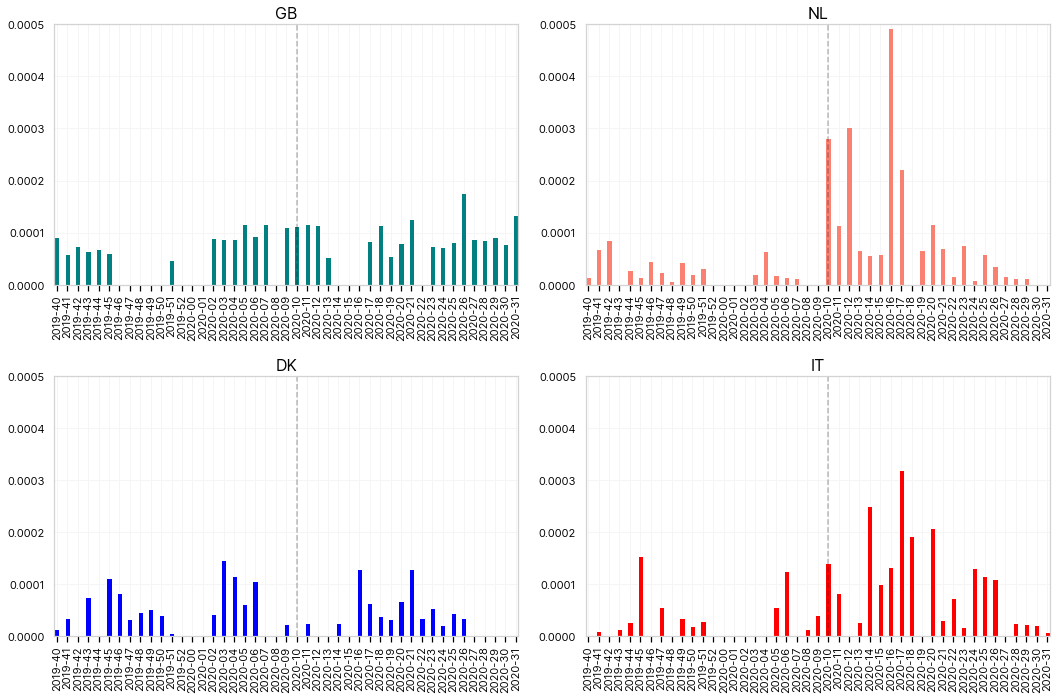

In [77]:
fig,ax = plt.subplots(2,2,figsize=(15,10))
colors = ["teal","salmon","blue","red"]

for c,l in enumerate(["gb","nl","dk","it"]):
    ax.reshape(-1)[c].bar(freqdata['week'],freqdata[l],color=colors[c],width=0.5)
    ax.reshape(-1)[c].title.set_text(l.upper())
    ax.reshape(-1)[c].axvline(x=23, color='k', linestyle='--', alpha=0.3)
plt.setp(ax, ylim=(0,0.0005))
for ax_ in ax.reshape(-1):
    for label in ax_.get_xticklabels():
        label.set_rotation(90) 
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
